Two high-level analyses:
- Predict performance (accuracy) using a regression
- Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

For github issues and brainstorming features and analyses, use github:
- https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser as parser
import time
from datetime import datetime
import csv
users = pd.read_csv('ml-users.csv')

In [68]:
# Takes in the row and appends the row into the given file
def file_appender(row, created, user_info):
    if user_info not in created:
        with open('{0}.csv'.format(user_info), 'w', newline = '') as new_user:
            writer = csv.writer(new_user)
            created.append(user_info)
            writer.writerow(header)
    with open('{0}.csv'.format(user_info), 'a', newline = '') as edit_user:
        editor = csv.writer(edit_user)
        editor.writerow(row)
    return created

In [69]:
 # Parses through the csv and creates new csv for every user_id & event
with open('ml-interactions.csv', newline='') as data:
    reader = csv.reader(data)
    header = []
    users_created = []
    events_created = []
    for row in reader:
        if row[1] == 'user_id':
            header = row
        else:
            user_id = row[1]
            current_event = row[4]
            users_created = file_appender(row, users_created, user_id)
            events_created = file_appender(row, events_created, current_event)

In [2]:
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip') # load the full gzip tarball
#df_interactions = pd.read_csv('ml-interactions15000.csv')

# Do a little cleanup...
# In my initial analysis, i found that at least one row has a NaN value for an 'action' field. This should
# not happen. So, let's find that row (and others) that have this problem and remove them

# pd.isna checks for missing values (NaN values). It returns a boolean array where the index corresponds to
# row and the value corresponds to True/False indicating whether there is a NaN value
isna_result = pd.isna(df_interactions['action'])

print("Printing all rows where 'action' == NaN...")
display(df_interactions[isna_result])
df_interactions= df_interactions[~isna_result] # we want all rows where isna is False (that is, all rows *without* a NaN for 'action')

# As a test, we can again look for NaN 'action' cells
isna_result = pd.isna(df_interactions['action'])
print("Printing all rows where 'action' == NaN... there should be no rows")
display(df_interactions[isna_result])
#small represents the first 50000 actions logged to be able to test a smaller subset
small= df_interactions[:50000]

Printing all rows where 'action' == NaN...


,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id
18502779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Printing all rows where 'action' == NaN... there should be no rows


,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id


In [3]:
# This fucntion iterates over the desired dataset and returns all of the logged events
# that contains the desired action
def find_action(args, use_subset = False):        
    for index, word in enumerate(args):  
        if use_subset:
            if index == 0:
                df_information = small[small['action'].str.contains(word)]
            else:
                frames = [df_information, small[small['action'].str.contains(word)]]
                df_information = pd.concat(frames)
        else:
            if index == 0:
                df_information = df_interactions[df_interactions['action'].str.contains(word)]
            else:
                frames = [df_information, df_interactions[df_interactions['action'].str.contains(word)]]
                df_information = pd.concat(frames)
    return df_information

In [4]:
# Used to create a correlation between accuracy and the info type that was given
# It accepts *args of strings for the actions that will be used to record the info type
# graph_type determines how the information is shown and multi_plot determines if it can
# be shows in per panos & per mission
def counting_graph (info_type, graph_type, multi_plot, use_subset, *args):
    user_information = {}
    user_panos = {}
    user_missions = {}
    df_information = find_action(args, use_subset)
    df_actions_grouped = df_information.groupby(['user_id'])
    df_all_grouped = df_interactions.groupby(['user_id'])
    for index, current_id in enumerate(df_actions_grouped.groups):
        user_information[current_id] = len(df_actions_grouped.get_group(current_id)), users[' accuracy'][index]
        if multi_plot:
            user_panos[current_id] = df_all_grouped.get_group(current_id)['gsv_panorama_id'].nunique()
            user_missions[current_id] = df_all_grouped.get_group(current_id)['mission_id'].nunique()
    if graph_type == 'scatter_plot':
        scatter_plot(info_type, user_information, user_panos, user_missions, multi_plot)
    elif graph_type == 'histogram':
        histogram(info_type, user_information)

In [5]:
# In progress
def range_graph(info_type, graph_type, use_subset, *args):
    user_information = {}
    df_information = find_action(args, use_subset)
    df_actions_grouped = df_information.groupby(['user_id'])
    for index, current_id in enumerate(df_actions_grouped.groups):
        current_min = df_actions_grouped.get_group(current_id).min()
        current_max = df_actions_grouped.get_group(current_id).max()
        current_accuracy = users[' accuracy'][index]
        user_information[current_id] = current_max - current_min, current_accuracy
    if graph_type == 'scatter_plot' :
        scatter_plot(info_type, user_information, None, None, False)

In [6]:
# Determines the average time it takes for a certain action to occur per second and per
# either panos or mission
# The type of information is found using the *args of actions logged
def time_graph(info_type, use_subset, *args):
    user_panos = {}
    user_missions = {}
    df_info  = find_action(args, use_subset)
    df_per_pano = df_info.groupby(['user_id', 'gsv_panorama_id'])
    df_per_mission = df_info.groupby(['user_id','mission_id'])
    current_group_times = []
    for name,group_pano in df_per_pano:
        for current_datetime in group_pano['ml-interactions.csv']:
            current_group_times.append(parser.parse(current_datetime))
        if name[0] in user_panos:
            user_panos[name[0]] = user_panos[name[0]] + (max(current_group_times) - min(current_group_times)).total_seconds()
        else:
            user_panos[name[0]] = (max(current_group_times) - min(current_group_times)).total_seconds()
    for name,group_mission in df_per_mission:
        for current_datetime in group_mission['ml-interactions.csv']:
            current_group_times.append(parser.parse(current_datetime))
        if name[0] in df_per_mission:
            user_missions[name[0]] = user_missions[name[0]] + (max(current_group_times) - min(current_group_times)).total_seconds()
        else:
            user_missions[name[0]] = (max(current_group_times) - min(current_group_times)).total_seconds()
    time_scatter_plot(info_type, user_panos, user_missions)

In [7]:
# Creates a scatter plot relating accuracy and the occurance of an action per second per
# panos or mission
def time_scatter_plot(info_type, user_panos, user_missions):
    f, axs = plt.subplots(1,2,figsize=(12,4))
    plt.subplot(122)
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type + ' per second per Pano')
    for index, entry in enumerate(user_panos.keys()):
        user_info = user_panos.get(entry)
        info = float(user_info)
        accuracy = users[' accuracy'][index]
        plt.plot(info, accuracy, '.', color = 'blue')
    plt.subplot(121)
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type + ' per second per Mission Started')
    for index, entry in enumerate(user_missions.keys()):
        user_info = user_missions.get(entry)
        info = float(user_info)
        accuracy = users[' accuracy'][index]
        plt.plot(info, accuracy, '.', color = 'blue')

In [8]:
# Creates a scatter plot of the information given, if multi_plot is true then it is also
# divided by the number of unique panos seens and missions started
def scatter_plot(info_type, user_information, user_panos, user_missions, multi_plot):
    if multi_plot:
        f, axs = plt.subplots(1,3,figsize=(12,4))
        plt.subplot(133)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type + ' per Pano')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_panos[entry])
            accuracy = user_info[1]
            plt.plot(info, accuracy, '.', color = 'blue')
        plt.subplot(132)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type + ' per Mission Started')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_missions[entry])
            accuracy = user_info[1]
            plt.plot(info, accuracy, '.', color = 'blue')
        plt.subplot(131)
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type)
    for entry in user_information.keys():
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        plt.plot(info, accuracy, '.', color = 'blue')

In [9]:
#Creates a histogram counting the occurances of a certain type of information
def histogram(info_type, user_information):
    plt.hist(user_information) 
    plt.xlabel(info_type)
    plt.ylabel('Count')

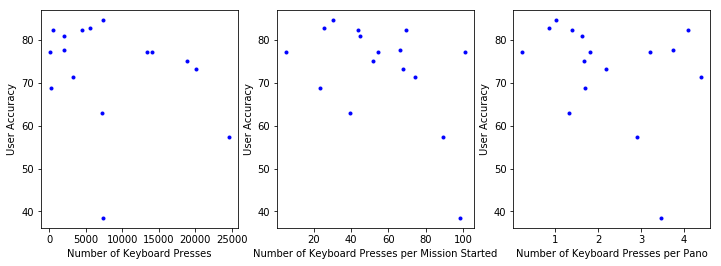

In [10]:
# Counts the number of keyboard presses
counting_graph('Number of Keyboard Presses', 'scatter_plot', True, False, 'LowLevelEvent_keydown')

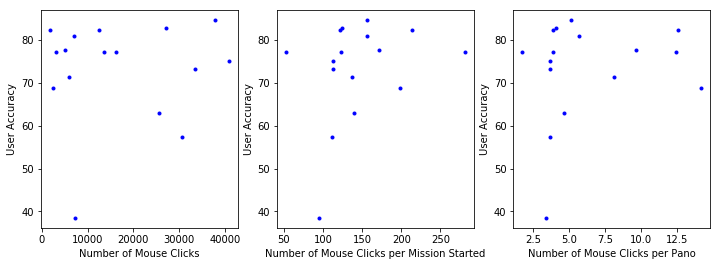

In [11]:
# Counts the number of mouse clicks
counting_graph('Number of Mouse Clicks', 'scatter_plot', True, False, 'LowLevelEvent_mousedown')

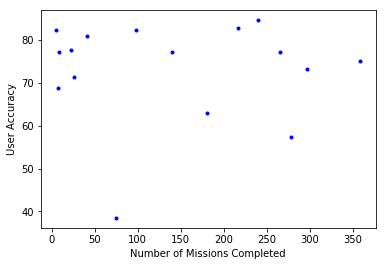

In [12]:
# Counts the number of missions completed
counting_graph('Number of Missions Completed', 'scatter_plot', False, False, 'MissionComplete')

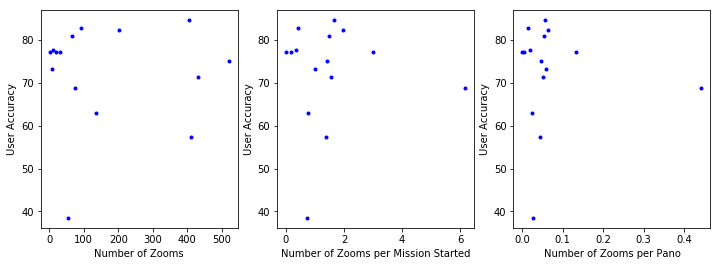

In [13]:
# Counts the number of zooms
counting_graph('Number of Zooms', 'scatter_plot', True, False, 'Click_ZoomIn')

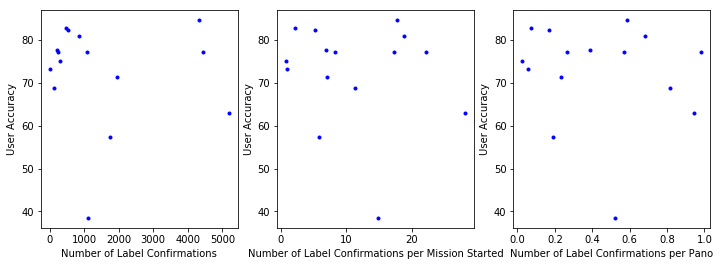

In [14]:
# Counts the number of Labels confirmations based off of clicking the OK button
counting_graph('Number of Label Confirmations', 'scatter_plot', True, False, 'ContextMenu_OKButtonClick')

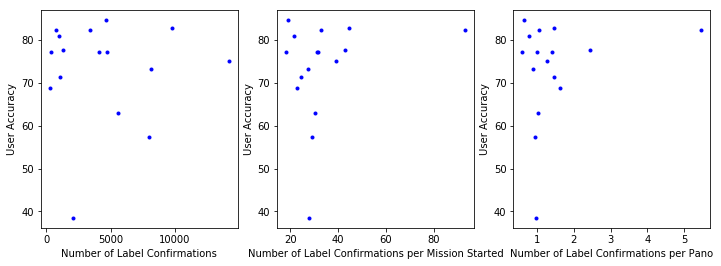

In [15]:
# Counts the number of Label Confirmation based off of closing the context window
# I am currently unsure whether this one or the one above would be a more accurate measure
# of labels done and what the other would represent
counting_graph('Number of Label Confirmations', 'scatter_plot', True, False, 'ContextMenu_Close')

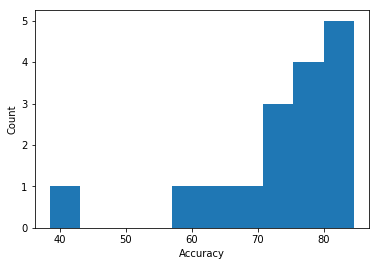

In [16]:
# Counts the number of users with different accuracies
histogram('Accuracy', users[' accuracy'])

In [17]:
# For the bottom three graphs, I was unable to run the entire dataset without notebooks 
# crashing. Below are when I use just the first 50000 lines of the whole dataset

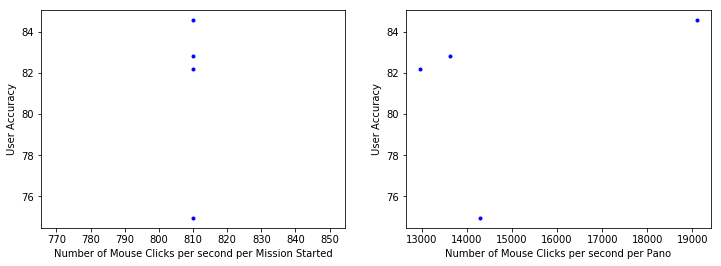

In [18]:
# # Counts the number of mouse clicks per second
time_graph('Number of Mouse Clicks', True, 'LowLevelEvent_mousedown')

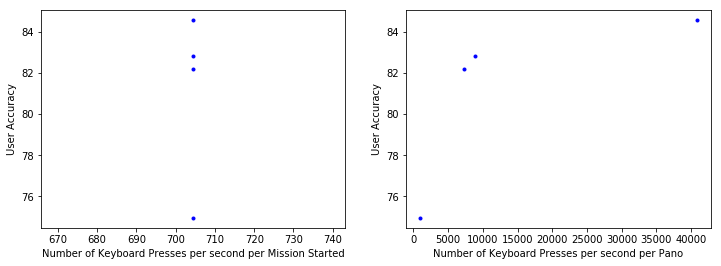

In [19]:
# Counts the number of keyboard presses per second
time_graph('Number of Keyboard Presses', True, 'LowLevelEvent_keydown')

In [20]:
# Counts the number of comments written
# in progress
# My current logic is to count the numver of times the textbox blurs but also take out the
# counts of when the context menu is closed since the textbox will always blur when the 
# context menu is closed
# There are currently negative numbers, unsure what is the current cause
user_information = {}
user_panos = {}
user_missions = {}
df_comments = find_action('ContextMenu_TextBoxBlur', True)
df_window_closes = find_action('ContextMenu_Close')
df_comments_grouped = df_comments.groupby(['user_id'])
df_window_closes_grouped = df_window_closes.groupby(['user_id'])
df_all_grouped = df_interactions.groupby(['user_id'])
for index, current_id in enumerate(df_comments_grouped.groups):
    user_information[current_id] = len(df_comments_grouped.get_group(current_id)) - len(df_all_grouped.get_group(current_id)), users[' accuracy'][index]
    user_panos[current_id] = df_all_grouped.get_group(current_id)['gsv_panorama_id'].nunique()
    user_missions[current_id] = df_all_grouped.get_group(current_id)['mission_id'].nunique()
scatter_plot('Comments Written', user_information, user_panos, user_missions, True)

KeyboardInterrupt: 